# This notebook contains:

1. Pre-process data 
2. Perform surival analysis

### Import packages

In [124]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyoff
import plotly.graph_objs as go

import lifelines

### Upload original data

In [5]:
from google.colab import files
uploaded = files.upload()

Saving zh_data.csv to zh_data.csv


### Read and check stats

In [125]:
df = pd.read_csv('zh_data.csv',sep=',')
# Basic stats
print(df.info())
print("############")
print('Missing data:', df.isnull().any().any())
print("############")
if df.isnull().any().any():
  print("Number of missing values: ")
  print(f'{df.isnull().sum()}\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   team_name               100 non-null    object 
 1   max_editors             94 non-null     float64
 2   subscription_start      100 non-null    object 
 3   renewal_date            100 non-null    object 
 4   billing_frequency       100 non-null    object 
 5   mrr                     98 non-null     object 
 6   nb_styleguides          100 non-null    int64  
 7   last_styleguide_update  100 non-null    object 
 8   nb_custom_domains       100 non-null    int64  
 9   is_sso_set_up           100 non-null    bool   
 10  last_week_viewers       83 non-null     float64
 11  last_month_viewers      95 non-null     float64
dtypes: bool(1), float64(3), int64(2), object(6)
memory usage: 8.8+ KB
None
############
Missing data: True
############
Number of missing values: 
team_n

### Data transformation

In [126]:
# Date transformation for subscription start date
df['subscription_start'] = df['subscription_start'].str.replace(r'/', '-')
# Date transformation for renewal date
df['renewal_date'] = df['renewal_date'].str.replace(r'/', '-')
# Date transformation for last style guide date
df['last_styleguide_update'] = df['last_styleguide_update'].str.replace(r'/', '-')

# Convert data fields from string to datetime data type
df[['subscription_start',
      'renewal_date',
      'last_styleguide_update']] = df[['subscription_start',
                                         'renewal_date',
                                         'last_styleguide_update']].apply(pd.to_datetime, 
                                                                          format='%d-%m-%Y')
# Currency transformation - split currency and number
df['currency'] = df['mrr'].str[0]
df['mrr'] = df['mrr'].str[1:]
mrr = df['mrr'].str.split(".",n=0, expand = True)
df["mrr"]= mrr[0]
# Convert monthly recurring revenue from string to float data type
df['mrr'] = df['mrr'].str.replace(r',', '').astype(float)

df.head(5)

,team_name,max_editors,subscription_start,renewal_date,billing_frequency,mrr,nb_styleguides,last_styleguide_update,nb_custom_domains,is_sso_set_up,last_week_viewers,last_month_viewers,currency
0,TEAM001,10.0,2020-12-09,2021-12-09,Yearly,792.0,1,2021-06-04,0,False,31.0,59.0,$
1,TEAM002,25.0,2021-01-27,2022-01-27,Yearly,995.0,4,2021-06-07,0,False,6.0,24.0,$
2,TEAM003,10.0,2020-07-15,2022-07-14,Yearly,369.0,1,2021-05-27,0,False,2.0,25.0,$
3,TEAM004,10.0,2020-08-31,2021-08-31,Yearly,658.0,1,2021-05-24,0,False,1.0,18.0,$
4,TEAM005,10.0,2020-06-29,2021-06-30,Yearly,270.0,1,2021-05-20,1,True,7.0,12.0,$


In [127]:
# Create end_date field as the extraction date
df['end_date'] = '06-07-2021'
df[['end_date']] = df[['end_date']].apply(pd.to_datetime, format='%d-%m-%Y')
df['days_between_renewaldate_enddate'] = df['end_date'] - df['renewal_date'] 

# Converts the difference in terms of weeks
df['days_between_renewaldate_enddate']=df['days_between_renewaldate_enddate']/np.timedelta64(1,'D') 

# Inspect abnormal data: subset customers who have renewal date prior to extraction date
df_inspect = df.loc[df['days_between_renewaldate_enddate'] > 0,:]
df_inspect

,team_name,max_editors,subscription_start,renewal_date,billing_frequency,mrr,nb_styleguides,last_styleguide_update,nb_custom_domains,is_sso_set_up,last_week_viewers,last_month_viewers,currency,end_date,days_between_renewaldate_enddate
4,TEAM005,10.0,2020-06-29,2021-06-30,Yearly,270.0,1,2021-05-20,1,True,7.0,12.0,$,2021-07-06,6.0
23,TEAM024,10.0,2020-05-18,2021-05-18,Yearly,NaN,2,2021-05-19,0,True,13.0,67.0,NaN,2021-07-06,49.0
29,TEAM030,25.0,2020-06-30,2021-06-30,Yearly,938.0,5,2021-06-04,1,True,101.0,350.0,$,2021-07-06,6.0
35,TEAM036,5.0,2020-06-10,2021-06-10,Yearly,619.0,1,2020-11-06,0,True,NaN,NaN,$,2021-07-06,26.0
58,TEAM059,NaN,2019-09-13,2021-06-16,Monthly,625.0,4,2021-06-01,1,True,NaN,12.0,$,2021-07-06,20.0
61,TEAM062,5.0,2021-05-14,2021-04-14,Yearly,NaN,4,2021-06-04,0,False,NaN,10.0,NaN,2021-07-06,83.0
90,TEAM091,30.0,2020-06-10,2021-06-10,Yearly,1250.0,8,2021-04-16,0,True,5.0,30.0,$,2021-07-06,26.0


In [129]:
# Convert GBP to USD using exchange rate of 1.37
df.loc[(df['currency'] == '£') , 'mrr'] = df['mrr']*1.37

# Exclude records with missing monthly recurring revenue
df = df.loc[df['mrr']>0,:]

# Create cohort year, cohort month from subscription date
df['cohort_year'] =  pd.DatetimeIndex(df['subscription_start']).year
df['cohort_month'] =  pd.DatetimeIndex(df['subscription_start']).month

# Calculate length of customer relationship 
"""
For customers with renewal date after end date:
  Lenght of customer relationship is counted from subscription date until the data extraction date 06-07-2021
"""

# Converts the difference in terms of months 
df['diff_months'] = df['end_date'] - df['subscription_start'] 
df['diff_months']=df['diff_months']/np.timedelta64(1,'M') 


# Create 'max_editors_group' field based on max. number of editors
"""Source: https://zeroheight.com/pricing"""

# According to the source, minimum number of editor = 1. Therefore:
## Blank record => labelled as unknown customer
df['max_editors_group'] = 'unknown'
## More than 10 editors => enterprise customer
df.loc[df['max_editors']  > 10,'max_editors_group'] = 'enterprise'
## Less or equal to 10 editors => company customer
df.loc[(df['max_editors']  <= 10) ,'max_editors_group'] = 'company'


# Create 'style_guide_group' field based on number of styleguides offered
"""Source: https://zeroheight.com/pricing"""

df['styleguide_group'] = 'only 1 styleguide'
df.loc[df['nb_styleguides']  > 3,'styleguide_group'] = 'more than 3 styleguides'
df.loc[(df['nb_styleguides']  <= 3) & (df['nb_styleguides']  > 1) ,'styleguide_group'] = '2-3 styleguides'

# Check
df.head(5)

,team_name,max_editors,subscription_start,renewal_date,billing_frequency,mrr,nb_styleguides,last_styleguide_update,nb_custom_domains,is_sso_set_up,last_week_viewers,last_month_viewers,currency,end_date,days_between_renewaldate_enddate,cohort_year,cohort_month,diff_months,max_editors_group,styleguide_group
0,TEAM001,10.0,2020-12-09,2021-12-09,Yearly,792.0,1,2021-06-04,0,False,31.0,59.0,$,2021-07-06,-156.0,2020,12,6.866671,company,only 1 styleguide
1,TEAM002,25.0,2021-01-27,2022-01-27,Yearly,995.0,4,2021-06-07,0,False,6.0,24.0,$,2021-07-06,-205.0,2021,1,5.256781,enterprise,more than 3 styleguides
2,TEAM003,10.0,2020-07-15,2022-07-14,Yearly,369.0,1,2021-05-27,0,False,2.0,25.0,$,2021-07-06,-373.0,2020,7,11.696339,company,only 1 styleguide
3,TEAM004,10.0,2020-08-31,2021-08-31,Yearly,658.0,1,2021-05-24,0,False,1.0,18.0,$,2021-07-06,-56.0,2020,8,10.152159,company,only 1 styleguide
4,TEAM005,10.0,2020-06-29,2021-06-30,Yearly,270.0,1,2021-05-20,1,True,7.0,12.0,$,2021-07-06,6.0,2020,6,12.222017,company,only 1 styleguide


### Explode data on monthly basis

In [130]:
# Calculate the maximum of the length of customer relationship in months
df['diff_months_int'] = df['diff_months'].astype(int)
max_month = df.diff_months_int.max()+1

# Iterate through each customer, multiple each record with max number of months
for i in enumerate(df.team_name):
  mf = pd.concat([df]*max_month, ignore_index=True)

# Create field 'count' as cumulative count of a customer relationship length
mf['count'] = mf.groupby(['team_name']).cumcount()

# Only keep the rows according to actual lenght of customer relationship
mf['limit'] = mf['diff_months'] - mf['count']
mf = mf.loc[mf['limit']>=0,:]

# create field 'month' for consecutive months since subscription date
mf['month'] = mf['cohort_month']
mf.loc[(mf['count'] == 0) , 'month'] = mf['cohort_month']
mf.loc[(mf['count'] == 1) & (mf['cohort_month'] == 12), 'month'] = 1
mf.loc[((mf['cohort_month'] <= 12)&(mf['month'] > 0)), 'month'] = mf['cohort_month']+mf['count']
mf.loc[((mf['month'] >12) &(mf['month'] < 25) ), 'month'] = mf['month']-12
mf.loc[(mf['month'] >=25  ), 'month'] = mf['month']-24

# create field 'year' for consecutive years since subscription date
mf['year'] = mf['cohort_year']
mf.loc[(mf['month'] == mf['cohort_month'] + mf['count'] ), 'year'] = mf['year']
mf.loc[(mf['cohort_month'] + mf['count'] >=13 ), 'year'] =  mf['cohort_year'] + 1
mf.loc[(mf['cohort_month'] + mf['count'] >=25 ), 'year'] = mf['cohort_year'] + 2

# create combined "year-month" field
mf['year_month'] = mf['year'].astype(str) + "-" + [str(i).zfill(2) for i  in mf['month']]
mf['cohort_year_month'] = mf['cohort_year'].astype(str) + "-" + [str(i).zfill(2) for i  in mf['cohort_month']]


### Snapshot of new data

In [131]:
test = mf.loc[mf.team_name == 'TEAM001',:]
test.head(100)


,team_name,max_editors,subscription_start,renewal_date,billing_frequency,mrr,nb_styleguides,last_styleguide_update,nb_custom_domains,is_sso_set_up,last_week_viewers,last_month_viewers,currency,end_date,days_between_renewaldate_enddate,cohort_year,cohort_month,diff_months,max_editors_group,styleguide_group,diff_months_int,count,limit,month,year,year_month,cohort_year_month
0,TEAM001,10.0,2020-12-09,2021-12-09,Yearly,792.0,1,2021-06-04,0,False,31.0,59.0,$,2021-07-06,-156.0,2020,12,6.866671,company,only 1 styleguide,6,0,6.866671,12,2020,2020-12,2020-12
98,TEAM001,10.0,2020-12-09,2021-12-09,Yearly,792.0,1,2021-06-04,0,False,31.0,59.0,$,2021-07-06,-156.0,2020,12,6.866671,company,only 1 styleguide,6,1,5.866671,1,2021,2021-01,2020-12
196,TEAM001,10.0,2020-12-09,2021-12-09,Yearly,792.0,1,2021-06-04,0,False,31.0,59.0,$,2021-07-06,-156.0,2020,12,6.866671,company,only 1 styleguide,6,2,4.866671,2,2021,2021-02,2020-12
294,TEAM001,10.0,2020-12-09,2021-12-09,Yearly,792.0,1,2021-06-04,0,False,31.0,59.0,$,2021-07-06,-156.0,2020,12,6.866671,company,only 1 styleguide,6,3,3.866671,3,2021,2021-03,2020-12
392,TEAM001,10.0,2020-12-09,2021-12-09,Yearly,792.0,1,2021-06-04,0,False,31.0,59.0,$,2021-07-06,-156.0,2020,12,6.866671,company,only 1 styleguide,6,4,2.866671,4,2021,2021-04,2020-12
490,TEAM001,10.0,2020-12-09,2021-12-09,Yearly,792.0,1,2021-06-04,0,False,31.0,59.0,$,2021-07-06,-156.0,2020,12,6.866671,company,only 1 styleguide,6,5,1.866671,5,2021,2021-05,2020-12
588,TEAM001,10.0,2020-12-09,2021-12-09,Yearly,792.0,1,2021-06-04,0,False,31.0,59.0,$,2021-07-06,-156.0,2020,12,6.866671,company,only 1 styleguide,6,6,0.866671,6,2021,2021-06,2020-12


### Check cohort - revenue

In [132]:
# Check cohort - revenue retention
cohort_pivot = pd.pivot_table(mf, 
                              index= 'cohort_year_month',
                              columns = 'count',
                              values = 'mrr', 
                              aggfunc = pd.Series.sum)
cohort_pivot 

count,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
cohort_year_month,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-05,1042.0000,1042.0000,1042.0000,1042.0000,1042.0000,1042.0000,1042.0000,1042.0000,1042.0000,1042.0000,1042.0000,1042.0,1042.0,1042.0,1042.0,1042.0,1042.0,1042.0,1042.0,1042.0,1042.0,1042.0,1042.0,1042.0,1042.0,1042.0
2019-09,625.0000,625.0000,625.0000,625.0000,625.0000,625.0000,625.0000,625.0000,625.0000,625.0000,625.0000,625.0,625.0,625.0,625.0,625.0,625.0,625.0,625.0,625.0,625.0,625.0,NaN,NaN,NaN,NaN
2019-10,875.0000,875.0000,875.0000,875.0000,875.0000,875.0000,875.0000,875.0000,875.0000,875.0000,875.0000,875.0,875.0,875.0,875.0,875.0,875.0,875.0,875.0,875.0,875.0,NaN,NaN,NaN,NaN,NaN
2019-12,361.0000,361.0000,361.0000,361.0000,361.0000,361.0000,361.0000,361.0000,361.0000,361.0000,361.0000,361.0,361.0,361.0,361.0,361.0,361.0,361.0,361.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01,1283.0000,1283.0000,1283.0000,1283.0000,1283.0000,1283.0000,1283.0000,1283.0000,1283.0000,1283.0000,1283.0000,1283.0,1283.0,1283.0,1283.0,1283.0,1283.0,1283.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02,1878.0000,1878.0000,1878.0000,1878.0000,1878.0000,1878.0000,1878.0000,1878.0000,1878.0000,1878.0000,1878.0000,1878.0,1878.0,1878.0,1878.0,1878.0,1878.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03,1250.0000,1250.0000,1250.0000,1250.0000,1250.0000,1250.0000,1250.0000,1250.0000,1250.0000,1250.0000,1250.0000,1250.0,1250.0,1250.0,1250.0,1250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04,369.0000,369.0000,369.0000,369.0000,369.0000,369.0000,369.0000,369.0000,369.0000,369.0000,369.0000,369.0,369.0,369.0,369.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05,1250.0000,1250.0000,1250.0000,1250.0000,1250.0000,1250.0000,1250.0000,1250.0000,1250.0000,1250.0000,1250.0000,1250.0,1250.0,1250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
# Save output
mf.to_csv('zh_output1.csv')

## Customer churn



#### Prepare data

In [116]:
# Last month views - Replace Nan with 0
df['last_month_viewers'] = df['last_month_viewers'].replace(np.nan, 0)

# Max editor - Replace Nan with 1
df['max_editors'] = df['max_editors'].replace(np.nan, 1)

# Create 'churn' field 
"""
  If view per editor >= 1 => Not churned yet => labeled as 0
  If view per editor < 1 => Churned => labeled as 1
"""
df['view per editor'] = df['last_month_viewers']/df['max_editors'] 
df['churn'] = 1
df.loc[ df['view per editor']>=1,'churn'] = 0

# Subset data for churn analysis
cf = df[['team_name', 'diff_months','max_editors_group','styleguide_group', 'churn']]
cf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98 entries, 0 to 99
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   team_name          98 non-null     object 
 1   diff_months        98 non-null     float64
 2   max_editors_group  98 non-null     object 
 3   styleguide_group   98 non-null     object 
 4   churn              98 non-null     int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 4.6+ KB


In [122]:
cf.styleguide_group.unique()

array(['only 1 styleguide', 'more than 3 styleguides', '2-3 styleguides'],
      dtype=object)

#### Kaplan-Meier estimate

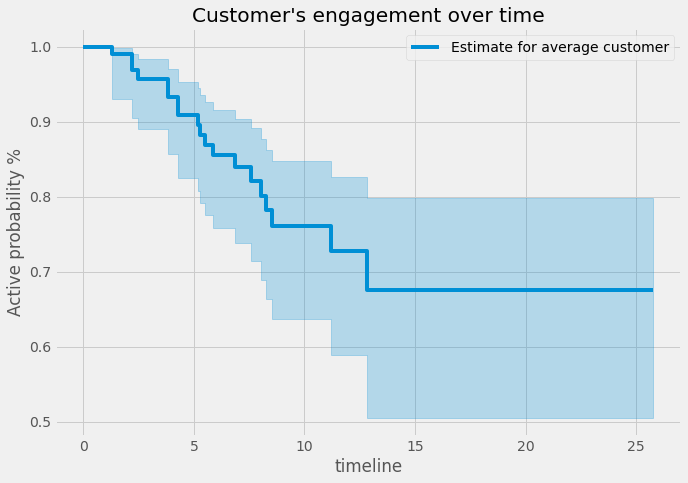

In [118]:
# Initialize timeline for observation  
T = cf['diff_months'].values

# Initialize churn status
E = cf['churn'].values

# Apply Kaplan Meier fitter from lifelines package
"""
https://lifelines.readthedocs.io/en/latest/index.html
"""
kmf = lifelines.KaplanMeierFitter()
kmf.fit(T, 
        event_observed=E, 
        label = 'Estimate for average customer')

# Plot
fig, ax = plt.subplots(figsize=(10,7))
kmf.plot(ax=ax)
ax.set_title("Customer's engagement over time")
ax.set_ylabel('Active probability %')

plt.show()

Text(0, 0.5, 'Active probability %')

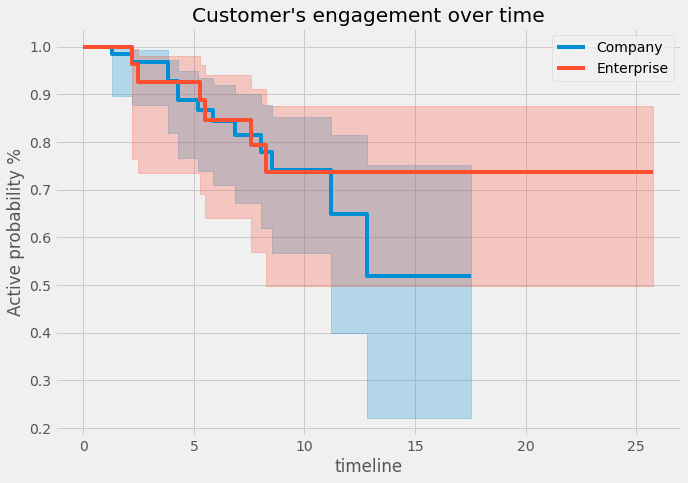

In [119]:
# Check customer's engagement for company VS enterprise customer type
plt.figure(figsize = (10,7))
ax = plt.subplot(111)
company = (cf["max_editors_group"] == "company")
kmf.fit(T[company], event_observed=E[company], label="Company")
kmf.plot_survival_function(ax=ax)

enterprise = (cf["max_editors_group"] == "enterprise")
kmf.fit(T[enterprise], event_observed=E[enterprise], label="Enterprise")
kmf.plot_survival_function(ax=ax)

ax.set_title("Customer's engagement over time")
ax.set_ylabel('Active probability %')

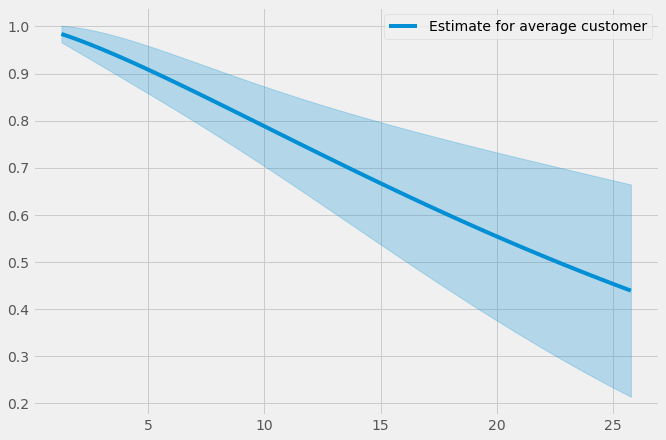

In [120]:

from lifelines import WeibullFitter
# Initialize timeline for observation  
T = cf['diff_months'].values

# Initialize churn status
E = cf['churn'].values

# Apply Weibull fitter from lifelines package
"""
https://lifelines.readthedocs.io/en/latest/index.html
"""
wf = lifelines.WeibullFitter()
wf.fit(T, 
        event_observed=E, 
        label = 'Estimate for average customer')
fig, ax = plt.subplots(figsize=(10,7))
wf.plot_survival_function()



Text(0, 0.5, 'Active probability %')

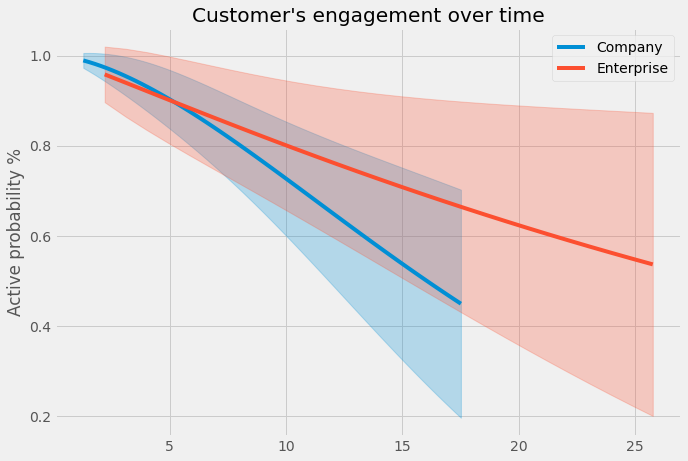

In [121]:
# Check customer's engagement for company VS enterprise customer type
plt.figure(figsize = (10,7))
ax = plt.subplot(111)
company = (cf["max_editors_group"] == "company")
wf.fit(T[company], event_observed=E[company], label="Company")
wf.plot_survival_function(ax=ax)

enterprise = (cf["max_editors_group"] == "enterprise")
wf.fit(T[enterprise], event_observed=E[enterprise], label="Enterprise")
wf.plot_survival_function(ax=ax)

ax.set_title("Customer's engagement over time")
ax.set_ylabel('Active probability %')

Text(0, 0.5, 'Active probability %')

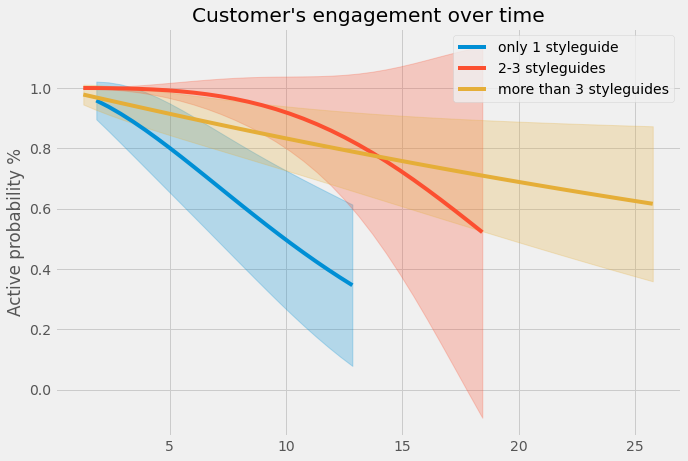

In [123]:
# Check customer's engagement, split by number of style guides
plt.figure(figsize = (10,7))
ax = plt.subplot(111)
one = (cf["styleguide_group"] == "only 1 styleguide")
wf.fit(T[one], event_observed=E[one], label="only 1 styleguide")
wf.plot_survival_function(ax=ax)

three = (cf["styleguide_group"] == "2-3 styleguides")
wf.fit(T[three], event_observed=E[three], label="2-3 styleguides")
wf.plot_survival_function(ax=ax)

more = (cf["styleguide_group"] == "more than 3 styleguides")
wf.fit(T[more], event_observed=E[more], label="more than 3 styleguides")
wf.plot_survival_function(ax=ax)

ax.set_title("Customer's engagement over time")
ax.set_ylabel('Active probability %')